<a href="https://colab.research.google.com/github/manojmahalik/PyTorch/blob/main/Pytorch_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
# import all required packages
import numpy as np

import torch
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

In [49]:
# Using GPU
CUDA = torch.cuda.is_available()
print("CUDA is available:",CUDA)

device = torch.device("cuda" if CUDA else "cpu")
print(device)


CUDA is available: True
cuda


In [50]:
# Helper Function to get number of correct classifications
def get_correct(preds, labels):
  preds[preds > 0.5] = 1
  preds[preds <= 0.5] = 0
  return torch.all(preds.eq(labels),dim=1).sum().item()

In [51]:
# Train Dataset for MNIST
train_set = torchvision.datasets.MNIST(
    root='./data/'
    ,train=True
    ,download=True
    ,transform=transforms.Compose([
                                    transforms.ToTensor()
    ]) 
)

# Test data set for MNIST
test_set = torchvision.datasets.MNIST(
    root='./data/'
    ,train=False
    ,download=True
    ,transform=transforms.Compose([
                                    transforms.ToTensor()
    ]) 
)

In [52]:
# Model for MNIST Digit classification and ADDER classification
# Input1 : 28x28 digit image to cov layer 1
# Input 2 : One-hot encoding of digit 0-9
# Output 1 : MNIST image digit classification in binary
# Output 2 : SUM of MNIST Digit and Input2 digit in binary

class Network(nn.Module):
  def __init__(self):
    super().__init__()
    # These act as attributes
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5) 
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)

    self.fc1 = nn.Linear(in_features=(12*4*4) + 10, out_features=120)
    self.fc2 = nn.Linear(in_features=120, out_features=40)
    self.out1 = nn.Linear(in_features=40, out_features=4)
    self.out2 = nn.Linear(in_features=40, out_features=5)

  def forward(self, t, d):

    #(1) input layer : not necessary to write- just for understanding purpose
    t = t

    #(2) hidden conv1 layer
    t = self.conv1(t)
    t = F.relu(t)
    t = F.max_pool2d(t, kernel_size=2, stride=2)

    #(3) hidden conv2 layer
    t = self.conv2(t)
    t = F.relu(t)
    t = F.max_pool2d(t, kernel_size=2, stride=2)

    #(4) hidden fc1 linear layer
    t = t.reshape(-1, 12*4*4)
    # Concatenating one hot encoding of input2 digit to FC layer
    t = torch.cat((t, d), dim=1) 
    t = self.fc1(t)
    t = F.relu(t)

    #(5) hidden fc2 linear layer
    t = self.fc2(t)
    t = F.relu(t)

    #(6) output linear layer with Sigmoid Activation
    t1 = self.out1(t)
    t1 = torch.sigmoid(t1)
    t2 = self.out2(t)
    t2 = torch.sigmoid(t2)

    return t1, t2

In [53]:
# Can write more on Decision on these params
num_epoch = 50 # number of times to iterate on complete dataset
batch_size = 200 # subset or records to fetch at once
learning_rate = 0.005 # Can be played around with for better

In [54]:
# Move the Neural network to GPU
network = Network().to(device)
print(network)

Network(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=202, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=40, bias=True)
  (out1): Linear(in_features=40, out_features=4, bias=True)
  (out2): Linear(in_features=40, out_features=5, bias=True)
)


In [55]:
# Create the Data Loader Objects
train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size) # for training iter
test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch_size) # for testing post each epoch
optimiser = optim.Adam(network.parameters(), lr=learning_rate)

In [56]:
# Helper function to convert integer tensor to rank-2 binary tensor
def convert_to_binary(number,width):
  temp = torch.empty(number.size()[0],width)
  for i,num in enumerate(number):
    temp[i] = torch.tensor([int(s) for s in np.binary_repr(num,width=width)])
  return temp

In [57]:
# metrics to capture as we train for multiple epochs : understand where are losses more, when it becomes flat, when to stop/ needs fixes
train_loss = []
train_lossMNIST = []
train_lossADDER = []

train_accMNIST = []
train_accADDER =[]

test_accMNIST = []
test_accADDER = []    
    
    
for epoch in range(num_epoch):
    lossMNIST = 0
    lossADDER = 0

    accMNIST = 0
    accADDER = 0

    for batch in train_loader:

      images, labels = batch 
      images = images.to(device)
      labels = labels.to(device)

      # Random digits generated
      digits = torch.randint(0, 10, (batch_size,)) # batch_size rand ints
      digits_one = F.one_hot(digits, num_classes=10) # one hot encoding
      digits_one = digits_one.to(device)
      digits = digits.to(device)
      

      # Convert labels for both outputs to binary 
      labels_bin = convert_to_binary(labels,4).to(device)
      sum_labels_bin = convert_to_binary(digits + labels,5).to(device)


      preds1, preds2 = network(images, digits_one) # Pass Batch
      loss1 = F.binary_cross_entropy(preds1, labels_bin) # Calculate Loss
      loss2 = F.binary_cross_entropy(preds2, sum_labels_bin) # Calculate Loss

      loss = loss1 + loss2

      optimiser.zero_grad()  # Set the gradients to zero
      loss.backward() #Calculating Gradients
      optimiser.step() # Updating the weights

      # Calculate total loss for all the batches in the train set
      lossMNIST += loss1.item()
      lossADDER += loss2.item()

      # Calculate total correct predictions for each Batch
      accMNIST += get_correct(preds1, labels_bin)
      accADDER += get_correct(preds2, sum_labels_bin)

    train_loss.append(lossMNIST + lossADDER)
    train_lossMNIST.append(lossMNIST)
    train_lossADDER.append(lossADDER)

    train_accMNIST.append((accMNIST/len(train_set))*100)
    train_accADDER.append((accADDER/len(train_set))*100)
  
    print('epoch:', epoch, 'Train Loss MNIST:', lossMNIST, '; Train Loss Adder: ', lossADDER \
          , 'Train Accuracy MNIST: ', accMNIST*100/len(train_set), 'Train Accuracy Adder: ', accADDER*100/len(train_set))

  # Predicting on test data using the trained network post every epoch of training
    accMNIST = 0
    accADDER = 0
  
    for batch in test_loader:
      images, labels = batch
      images = images.to(device)
      labels = labels.to(device)

      # Random digits generated
      digits = torch.randint(0, 10, (batch_size,)) # batch_size rand ints
      digits_one = F.one_hot(digits, num_classes=10) # one hot encoding 0-9 : 10 different values : *could improvised here*
      digits_one = digits_one.to(device)
      digits = digits.to(device)

      # Convert labels for both outputs to binary 
      labels_bin = convert_to_binary(labels,4).to(device)
      sum_labels_bin = convert_to_binary(digits + labels,5).to(device)

      # Do predictions
      preds1, preds2 = network(images, digits_one)

      accMNIST += get_correct(preds1, labels_bin)
      accADDER += get_correct(preds2, sum_labels_bin)

    test_accMNIST.append((accMNIST/len(test_set))*100)
    test_accADDER.append((accADDER/len(test_set))*100)

    print('epoch:', epoch, 'test: Accuracy MNIST', accMNIST/len(test_set), '; Accuracy Adder: ', accADDER/len(test_set) )


epoch: 0 Train Loss MNIST: 66.00699485652149 ; Train Loss Adder:  146.04214504361153 Train Accuracy MNIST:  73.18833333333333 Train Accuracy Adder:  18.273333333333333
epoch: 0 test: Accuracy MNIST 0.9448 ; Accuracy Adder:  0.415
epoch: 1 Train Loss MNIST: 15.709340683650225 ; Train Loss Adder:  56.38243971019983 Train Accuracy MNIST:  95.155 Train Accuracy Adder:  66.98
epoch: 1 test: Accuracy MNIST 0.9609 ; Accuracy Adder:  0.8767
epoch: 2 Train Loss MNIST: 11.044278582790866 ; Train Loss Adder:  20.066802098415792 Train Accuracy MNIST:  96.56833333333333 Train Accuracy Adder:  92.6
epoch: 2 test: Accuracy MNIST 0.9669 ; Accuracy Adder:  0.937
epoch: 3 Train Loss MNIST: 9.342913321917877 ; Train Loss Adder:  14.539359527640045 Train Accuracy MNIST:  97.145 Train Accuracy Adder:  94.81
epoch: 3 test: Accuracy MNIST 0.9701 ; Accuracy Adder:  0.9475
epoch: 4 Train Loss MNIST: 7.979585795081221 ; Train Loss Adder:  11.99943369673565 Train Accuracy MNIST:  97.59333333333333 Train Accuracy

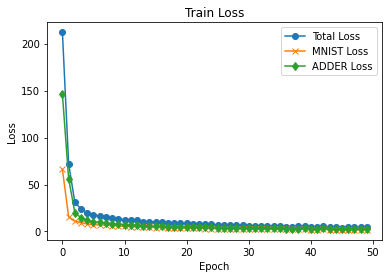

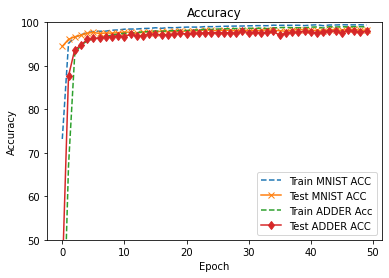

In [66]:
# Plotting metrics to check Model learning 
import matplotlib.pyplot as plt

plt.plot(range(epoch+1), train_loss, marker='o')
plt.plot(range(epoch+1), train_lossMNIST, marker = 'x')
plt.plot(range(epoch+1), train_lossADDER, marker = 'd')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Total Loss", "MNIST Loss", "ADDER Loss"])
plt.title("Train Loss")
#plt.ylim([0,100])
plt.show()

plt.plot(range(epoch+1), train_accMNIST, linestyle='dashed')
plt.plot(range(epoch+1), test_accMNIST, marker = 'x')
plt.plot(range(epoch+1), train_accADDER, linestyle='dashed')
plt.plot(range(epoch+1), test_accADDER, marker = 'd')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Train MNIST ACC", "Test MNIST ACC", "Train ADDER Acc", "Test ADDER ACC"])
plt.title("Accuracy")
plt.ylim([50,100])
plt.show()

### Functions to plot Classifications and show examples results
There could be 4 combinations :-

- Correct Image Class & Correct Addition

- Correct Image Class & Wrong Addition

- Wrong Image Class & Correct Addition

- Wrong Image Class & Wrong Addition

In [67]:
def correct_idx(a_c, p_c):
  correct_idx = torch.all(p_c.eq(a_c),dim=1).nonzero(as_tuple=True)
  return correct_idx

def wrong_idx(a_c, p_c):
  wrong_idx = torch.any(p_c.ne(a_c),dim=1).nonzero(as_tuple=True)
  return wrong_idx

def get_outputs(images,actual_class,pred_class,actual_sum,pred_sum,digits,class_id,sum_id):
  imgs = images[class_id][sum_id]
  lbls = actual_class[class_id][sum_id]
  predict_class = pred_class[class_id][sum_id]
  sums = actual_sum[class_id][sum_id]
  predict_sums = pred_sum[class_id][sum_id]
  rn = digits[class_id][sum_id]
  return imgs,lbls,predict_class,sums,predict_sums,rn

def show_results(imgs,lbls,predict_class,sums,predict_sums,rn,bgcolor = "white", tcolor = "black"):
  fig = plt.figure(figsize=(16,12), facecolor = bgcolor)
  img_count = len(imgs)
  if img_count == 0:
    print("All the additions for this batch was correct")
  elif img_count >= 1:
    if img_count > 3:
      img_count = 3
    for i in range(img_count):
      plt.subplot(1,img_count,i+1)
      plt.tight_layout()
      plt.imshow(imgs[i][0].to("cpu"), cmap='gray', interpolation='none')
      plt.title("Actual {} + {} = {} \n Predicted {} + {} = {}".format(lbls[i],rn[i],sums[i],
                                                              predict_class[i],rn[i],predict_sums[i]),
                color = tcolor)
      plt.xticks([])
      plt.yticks([])
    plt.show()

Results for Correct Image class and Correct additions


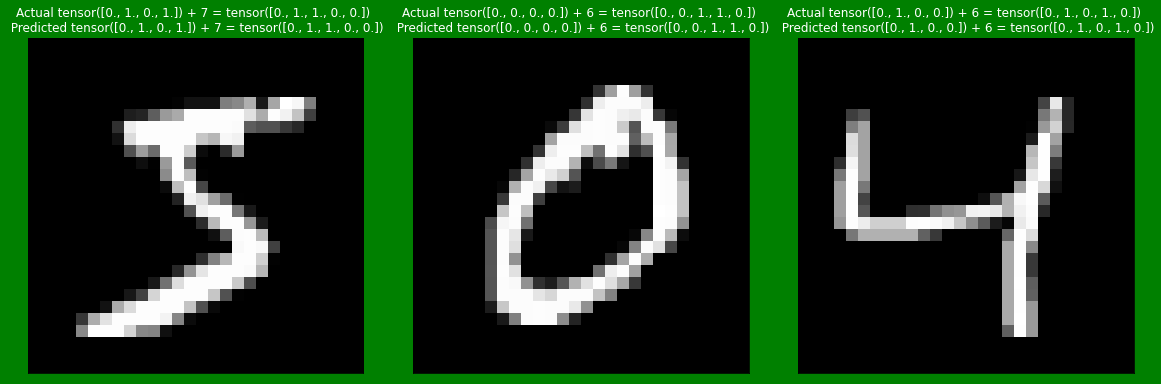

Results for Correct Image class and Wrong Additions


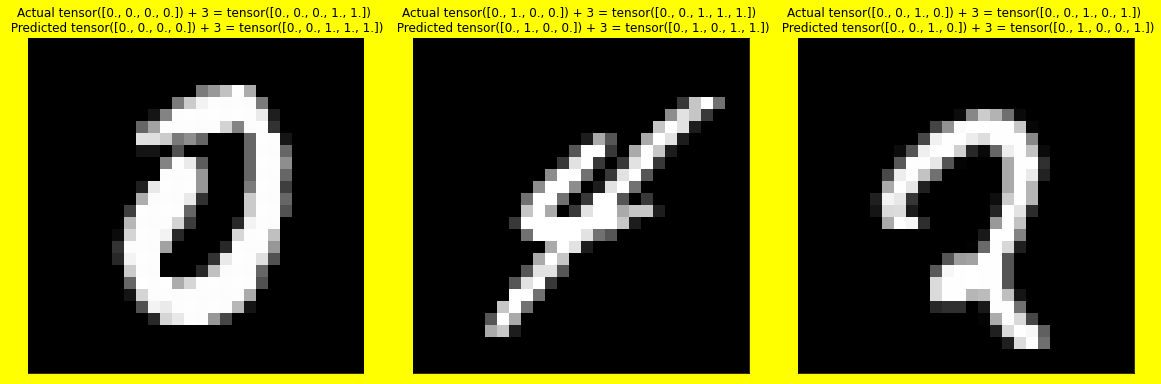

Results for Wrong Image class and Correct additions


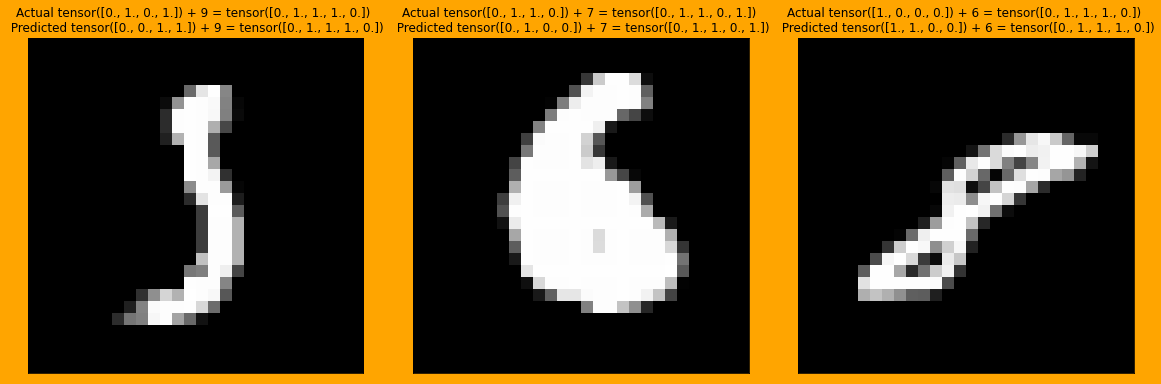

Results for Wrong Image class and Wrong Additions


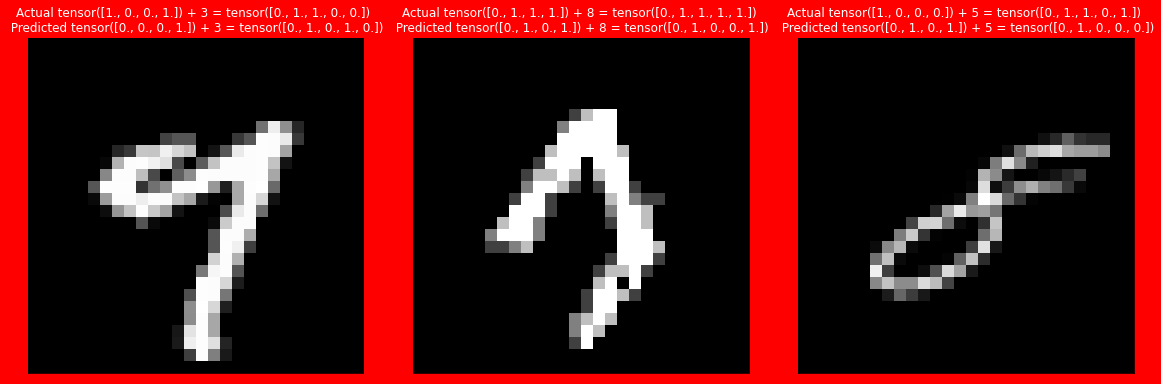

In [68]:
# Plotting the results correctly classified and wrongly classifed
# for images, labels in train_loader: 

batch_size = 4000
train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size)
j=1

class_all_correct_idx = torch.IntTensor()
sum_all_correct_idx = torch.IntTensor()

for images, labels in train_loader:
  images = images.to(device)
  labels = labels.to(device)

  # Random digits generated
  digits = torch.randint(0, 10, (batch_size,)) # 100 rand ints
  digits_one = F.one_hot(digits, num_classes=10) # one hot encoding
  digits_one = digits_one.to(device)
  digits = digits.to(device)

  # Run the model   
  preds_class_prob, preds_sum_prob = network(images, digits_one) # Pass Batch

  # Format the sigmoid outputs from multilabel output to zeros and ones
  pred_class = preds_class_prob.detach().to('cpu').apply_(lambda x: 1 if x > 0.5 else 0)
  pred_sum = preds_sum_prob.detach().to('cpu').apply_(lambda x: 1 if x > 0.5 else 0)

  # Convert the labels to binary
  actual_class = convert_to_binary(labels,4)
  actual_sum = convert_to_binary(labels+digits,5)

  # Get ID of the correct classification
  class_correct_idx = correct_idx(actual_class, pred_class)

  #Get IDs for correct Image and correct additions
  sum_correct_idx = correct_idx(actual_sum[class_correct_idx], pred_sum[class_correct_idx])
  imgs,lbls,predict_class,sums,predict_sums,rn = get_outputs(images,actual_class,pred_class,actual_sum,pred_sum,digits,class_correct_idx,sum_correct_idx)
  print("Results for Correct Image class and Correct additions")
  show_results(imgs,lbls,predict_class,sums,predict_sums,rn,"green",tcolor = "white")

  #Get IDs for Correct Image class and Wrong Additions
  sum_wrong_idx = wrong_idx(actual_sum[class_correct_idx], pred_sum[class_correct_idx])
  imgs,lbls,predict_class,sums,predict_sums,rn = get_outputs(images,actual_class,pred_class,actual_sum,pred_sum,digits,class_correct_idx,sum_wrong_idx)
  print("Results for Correct Image class and Wrong Additions")
  show_results(imgs,lbls,predict_class,sums,predict_sums,rn,"yellow")

  # Get ID of the correct classification
  class_wrong_idx = wrong_idx(actual_class, pred_class)

  #Get IDs for Wrong Image class and Correct additions
  sum_correct_idx = correct_idx(actual_sum[class_wrong_idx], pred_sum[class_wrong_idx])
  imgs,lbls,predict_class,sums,predict_sums,rn = get_outputs(images,actual_class,pred_class,actual_sum,pred_sum,digits,class_wrong_idx,sum_correct_idx)
  print("Results for Wrong Image class and Correct additions")
  show_results(imgs,lbls,predict_class,sums,predict_sums,rn,"orange")

  #Get IDs for Wrong Image class and Wrong Additions
  sum_wrong_idx = wrong_idx(actual_sum[class_wrong_idx], pred_sum[class_wrong_idx])
  imgs,lbls,predict_class,sums,predict_sums,rn = get_outputs(images,actual_class,pred_class,actual_sum,pred_sum,digits,class_wrong_idx,sum_wrong_idx)
  print("Results for Wrong Image class and Wrong Additions")
  show_results(imgs,lbls,predict_class,sums,predict_sums,rn,"red", tcolor = "white")

  if j ==1:
    break